# Large assignment 3

## Read before you start

* Provide clear and complete answers in code blocks or markdown. You may add as many as you need.
* Always motivate your answers. This can be done in markdown cells, or in comments in code.
* Submit your results via Brightspace. Use the following filename convention: ``StudentName1_snumber1_StudentName2_snumber2_LargeAssignment3.ipynb``.
* Make sure you submit a fully executed version of the notebook file. The teaching assistants will not run/debug your code during grading.
* Questions? Ask them during the workgroups, or see Brightspace for instructions on how to proceed.

In [22]:
!apt install jags
!pip install pyjags

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
jags is already the newest version (4.3.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pyjags as pj

print('Using PyJAGS v{:s}'.format(pj.__version__))

plt.rc('axes', titlesize=18)        # fontsize of the axes title
plt.rc('axes', labelsize=18)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)       # fontsize of the tick labels
plt.rc('ytick', labelsize=14)       # fontsize of the tick labels
plt.rc('legend', fontsize=12)       # legend fontsize
plt.rc('figure', titlesize=30)      # fontsize of the figure title

Using PyJAGS v1.3.8


# 1. Ageing and cognitive decline

One of the topics that is studied extensively at the Donders Institute is the effect of ageing on cognition (for example, if you are interested: https://www.ru.nl/donders/research/theme-3-plasticity-memory/research-groups-theme-3/cognitive-aging/). It is generally accepted that (on average), performance on cognitive tasks decreases as we grow older. In this exercise, we'll use Bayesian modelling and Bayesian model comparison to explore this further. Note: although the data were generated specifically for this exercise (that is, they are not real measurements), the setting is not unrealistic.

One of the scores that measures cognitive performance is the [Rey–Osterrieth Complex Figure](https://en.wikipedia.org/wiki/Rey%E2%80%93Osterrieth_complex_figure) (ROCF) assessment, which asks participants to redraw a complicated line drawing from memory. In this assignment, we'll assume the ROCF score has been measured and stored for different people in the same age range ($50-80$), but for two different groups: The first is the `control` group, which consists of regularly ageing people. The second group is a group that has been instructed, starting at age 50, to exercise at least 2 times a week. We will refer to this group as the `active` group.

The question is of course: __Does an active lifestyle reduce the effects of ageing on cognitive decline?__

The following code snippet loads and plots the ROCF scores for this exercise.

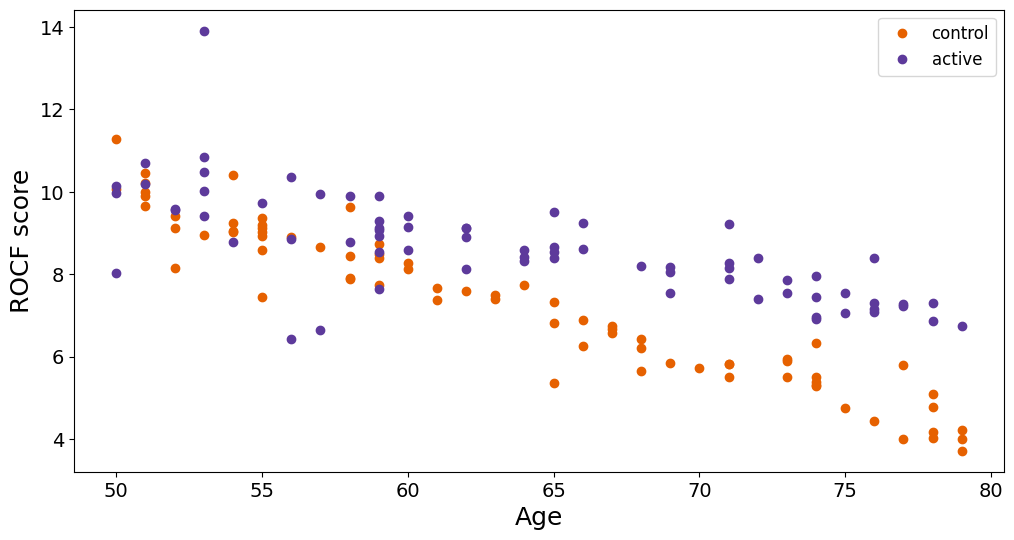

In [24]:
data = np.load('ROCF_data.npz')
x_control = data['x_control']
x_active = data['x_active']
y_control = data['y_control']
y_active = data['y_active']

labels = ['control', 'active']

plt.figure(figsize=(12, 6))
ax = plt.gca()
colors = ['#E66100', '#5D3A9B']

ax.plot(x_control, y_control, 'o', label=labels[0], color=colors[0])
ax.plot(x_active, y_active, 'o', label=labels[1], color=colors[1])
ax.set_xlabel('Age')
ax.set_ylabel('ROCF score')
ax.legend()

The approach to study this problem will, once more, be that of linear regression. Within that context, the research question translates into: __Is the difference between the slopes in linear regression of the control group, $\beta_1^c$ and the active group, $\beta_1^a$, nonzero?__

By looking at the data, there does appear to be a difference, although near the beginning (e.g. ages 50-60) there is still a lot of overlap.

Let's call this difference between the slopes $\delta=\beta_1^a - \beta_1^c$.

1. What is the null hypothesis ($m_0$), in terms of $\delta$?


_ANSWER:_

The null hypothesis is $\delta$ = 0, meaning the slopes have no difference.

In our alternative hypothesis ($m_1$), the difference in slopes $\delta$ is unknown.

2. Write down a generative model that uses all observations $(x_i^c, y_i^c)_{i=1}^{n^c}$ and $(x_i^a, y_i^a)_{i=1}^{n^a}$ to learn the distribution over $\delta$. Note: this is simply two separate linear regressions, with the addition of the $\delta$ term. The superscripts $\cdot^a$ and $\cdot^c$ are used to indicate the active and the control group, respectively. As always, be mindful of which distributions make sense for which variable (and note that $\delta$ is a _deterministic_ variable, and hence is not assigned a distribution!). Check the examples of linear regression in Lecture 6 if you are unsure.

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
updating: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 20000 of 20000, elapsed 0:00:02, remaining 0:00:00
Mean of delta: -0.09630281099317595
95% CI for delta: [-0.1249428  -0.06875723]


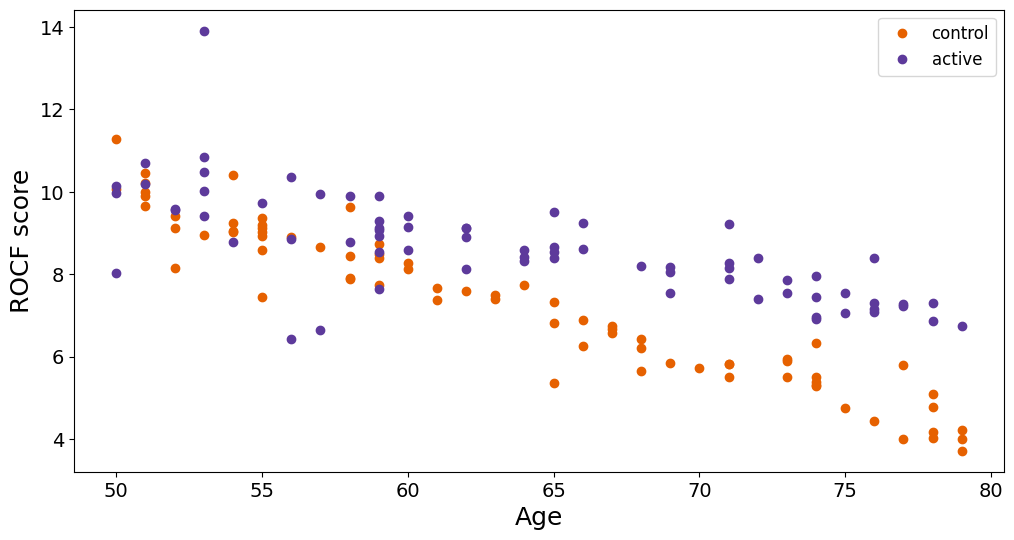

In [25]:
data_dict = {
    'x_c': x_control,
    'y_c': y_control,
    'n_c': len(x_control),
    'x_a': x_active,
    'y_a': y_active,
    'n_a': len(x_active)
}

jags_model = '''
model {
    # Priors for intercepts and slopes
    beta_c0 ~ dnorm(0, 0.01)  # Weakly informative normal prior for control intercept
    beta_a0 ~ dnorm(0, 0.01)  # Weakly informative normal prior for active intercept
    beta_c1 ~ dnorm(0, 0.01)  # Weakly informative normal prior for control slope
    beta_a1 ~ dnorm(0, 0.01)  # Weakly informative normal prior for active slope

    # Prior for the shared variance, using Gamma distribution for precision
    tau ~ dgamma(0.01, 0.01)  # Gamma prior for precision (inverse of variance)
    sigma_sq <- 1 / tau  # Convert precision to variance
    sigma <- sqrt(sigma_sq)  # Standard deviation

    # Likelihood for each group
    for (i in 1:n_c) {
        y_c[i] ~ dnorm(mu_c[i], sigma_sq)  # Normal likelihood for control group
        mu_c[i] <- beta_c0 + beta_c1 * x_c[i]  # Linear model for control group
    }

    for (i in 1:n_a) {
        y_a[i] ~ dnorm(mu_a[i], sigma_sq)  # Normal likelihood for active group
        mu_a[i] <- beta_a0 + beta_a1 * x_a[i]  # Linear model for active group
    }

    # Calculating delta
    delta <- beta_c1 - beta_a1  # Deterministic calculation of delta
}
'''

# Initialize the model in PyJAGS
model = pj.Model(jags_model, data=data_dict, chains=4, adapt=1000)

# Burn-in
model.update(1000)

# Sampling
samples = model.sample(5000, vars=['beta_c0', 'beta_a0', 'beta_c1', 'beta_a1', 'delta', 'sigma'])


plt.figure(figsize=(12, 6))
ax = plt.gca()
colors = ['#E66100', '#5D3A9B']
ax.plot(x_control, y_control, 'o', label='control', color=colors[0])
ax.plot(x_active, y_active, 'o', label='active', color=colors[1])
ax.set_xlabel('Age')
ax.set_ylabel('ROCF score')
ax.legend()

# Printing summary of delta to see the effect of an active lifestyle
delta_samples = samples['delta']
print(f"Mean of delta: {np.mean(delta_samples)}")
print(f"95% CI for delta: {np.percentile(delta_samples, [2.5, 97.5])}")

plt.show()

_ANSWER:_


3. Draw the graphical model that corresponds to your generative model. Make sure to pay attention to the correct repetition/indexing/shading and so on.

_ANSWER:_

As we saw in Large Assignment #2 and Lectures 7 & 8, there are multiple ways of figuring out the answer to this question. This time, we shall use the Region of Practical Equivalence (ROPE) approach.

4. The first step is to implement the model in JAGS and see if everything went alright - that is, we can once more plot the posterior expectations of $\mu_i^g = \beta_0^g + \beta_1^g x_i^g$, with $g\in\{a, c\}$. These expectations should be pretty good fits through the observed data points.

Much of the code for the visualization was already provided in Lecture 6 and Large Assignment 1, and is partially repeated below for your convenience.

_ANSWER:_

In [26]:
%%time

data = dict(x_control=x_control,
            x_active=x_active,
            y_control=y_control,
            y_active=y_active,
            n_control=len(x_control),
            n_active=len(x_active))

code = '''
model{
    # Priors for intercepts and slopes, renaming as w0 and w1
    w0[1] ~ dnorm(0, 0.01)  # Control intercept
    w1[1] ~ dnorm(0, 0.01)  # Control slope
    w0[2] ~ dnorm(0, 0.01)  # Active intercept
    w1[2] ~ dnorm(0, 0.01)  # Active slope

    # Prior for the shared variance
    tau <- 1 / (sigma * sigma)
    sigma ~ dunif(0, 100)

    # Likelihood for control group
    for (i in 1:n_control) {
        mu_c[i] <- w0[1] + w1[1] * x_control[i]
        y_control[i] ~ dnorm(mu_c[i], tau)
    }

    # Likelihood for active group
    for (i in 1:n_active) {
        mu_a[i] <- w0[2] + w1[2] * x_active[i]
        y_active[i] ~ dnorm(mu_a[i], tau)
    }

    # Calculate delta (difference in slopes)
    delta <- w1[1] - w1[2]
}
'''


num_samples = 10_000
num_chains = 4

m = pj.Model(code=code, data=data, chains=num_chains)
samples = m.sample(num_samples, vars=['w0', 'w1', 'sigma', 'delta'])

adapting: iterations 4000 of 4000, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:03, remaining 0:00:00
CPU times: user 2.76 s, sys: 5.81 ms, total: 2.76 s
Wall time: 2.77 s


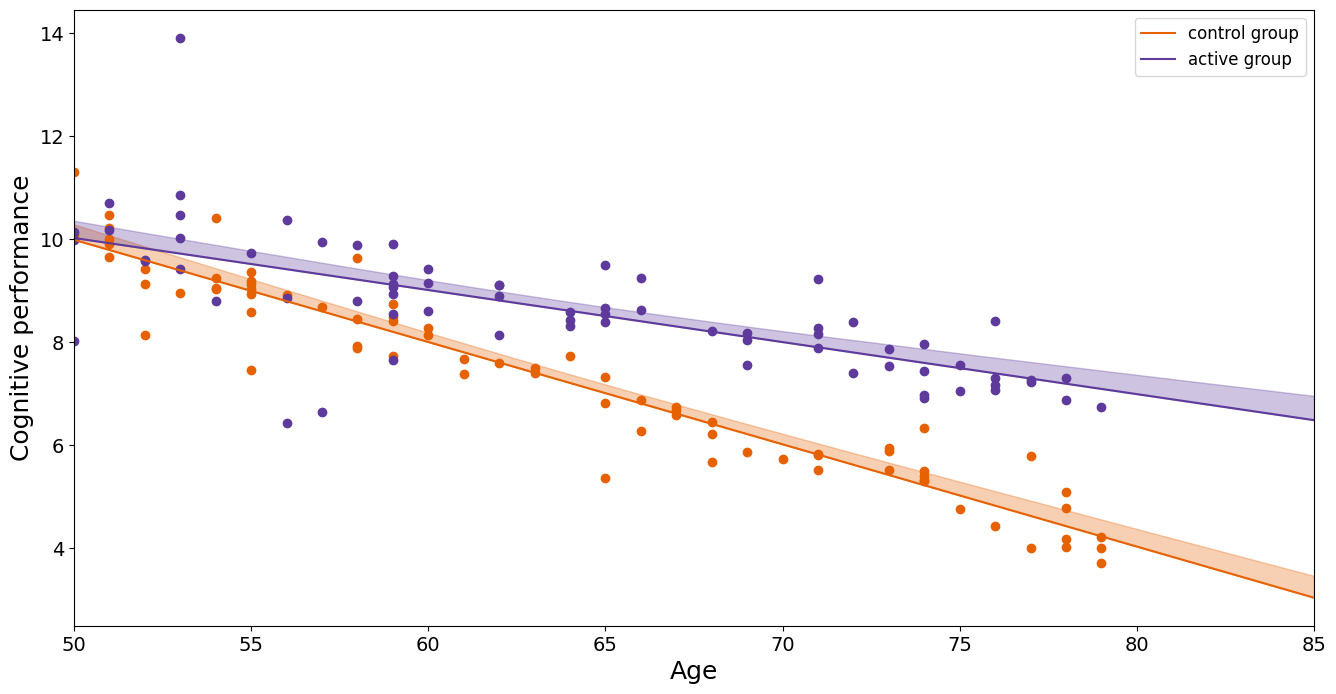

In [27]:
plt.figure(figsize=(16, 8))
ax = plt.gca()

ax.plot(x_control, y_control, 'o', color=colors[0])
ax.plot(x_active, y_active, 'o', color=colors[1])

m = 100
x_range = np.linspace(50, 85, num=m)
# Rename the variables to match your JAGS code!

w0_samples = np.reshape(samples['w0'], newshape=(2, num_samples*num_chains))
w1_samples = np.reshape(samples['w1'], newshape=(2, num_samples*num_chains))

x_repeat = np.repeat(x_range[:, np.newaxis], num_samples*num_chains, axis=1).T

for k in range(2):
    w0_repeat = np.repeat(w0_samples[k][:, np.newaxis], m, axis=1)
    w1_repeat = np.repeat(w1_samples[k][:, np.newaxis], m, axis=1)
    mu_samples = w0_repeat + w1_repeat*x_repeat

    mu_exp = np.mean(mu_samples, axis=0)
    mu_lower = np.mean(mu_samples, axis=0)
    mu_upper = mu_upper = np.percentile(mu_samples, 97.5, axis=0)

    ax.plot(x_range, mu_exp, color=colors[k],
            label=f'{labels[k]} group')
    ax.fill_between(x_range,
                    mu_lower,
                    mu_upper, color=colors[k], alpha=0.3)
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Cognitive performance')
ax.set_xlim([x_range[0], x_range[-1]]);
plt.show()

Once you are happy with the training of your model, we can continue with finding the answer to the research question. However, this time we have chosen the ROPE approach to model comparison / hypothesis testing. It is important that we define the ROPE __before__ we actually look at the posterior distribution of $\delta$, because otherwise we could just conveniently pick the ROPE to match our political agenda. __THIS. IS. VERY. BAD.__

To choose a ROPE, we have to figure out what we consider 'practically equivalent' with the null hypothesis value (which you determined in question #1). First, we need to have a bit of an intuition of what kind of values we can expect for the slopes $b_1^a$ and $b_1^c$, because that will also inform us about what a sensible difference is. By just looking at the data points, we can see that, for example, the control group drops about 6 ROCF points when age increases by 30, which gives us an educated guess of $\beta_1^c\approx 6/30=0.2$.

5. Determine your choice of the ROPE (the bounds of the interval around the value indicated by the null hypothesis). Note: there is not really a right answer here, but many answers could be wrong (for example, a ROPE of $[25, 30]$ seems weird to me). The point is that you think about what values for $\delta$ you expect, and consequently which values you think are pretty much equivalent to the null hypothesis value.





_ANSWER:_

In [28]:
ROPE = [-0.05, 0.05]

5. Make a figure showing the posterior distribution of the variable we are interested in, that is, show $p(\delta \mid \mathbf{x}^c, \mathbf{y}^c, \mathbf{x}^a, \mathbf{y}^a)$.

_ANSWER:_

Shape of delta_samples: (1, 5000, 4)


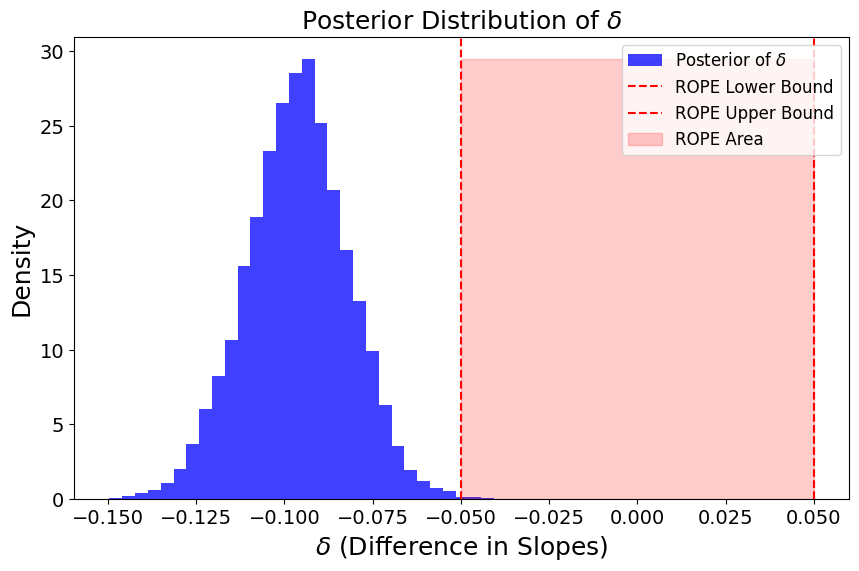

In [29]:
# Assuming delta_samples is correctly extracted from your model output
# Check the shape and ensure it's 1D
print("Shape of delta_samples:", np.shape(delta_samples))
delta_samples = delta_samples.reshape(-1)

# Plotting the posterior distribution of delta
plt.figure(figsize=(10, 6))
plt.hist(delta_samples, bins=30, density=True, color='blue', alpha=0.75, label='Posterior of $\\delta$')
plt.title('Posterior Distribution of $\\delta$')
plt.xlabel('$\\delta$ (Difference in Slopes)')
plt.ylabel('Density')

# Plotting the ROPE area
rope_lower, rope_upper = -0.05, 0.05
plt.axvline(x=rope_lower, color='red', linestyle='--', label='ROPE Lower Bound')
plt.axvline(x=rope_upper, color='red', linestyle='--', label='ROPE Upper Bound')
plt.fill_betweenx([0, max(np.histogram(delta_samples, bins=30, density=True)[0])],
                  rope_lower, rope_upper, color='red', alpha=0.2, label='ROPE Area')

plt.legend()
plt.show()

6. Determine the 95% HDI of $p(\delta \mid \mathbf{x}^c, \mathbf{y}^c, \mathbf{x}^a, \mathbf{y}^a)$ and indicate it clearly on top of your figure from the previous question (for example, with a horizontal line from the left bound of the HDI to the right bound of the HDI).

_ANSWER:_

95% HDI: [-0.12496264261643072, -0.06888306364316966]


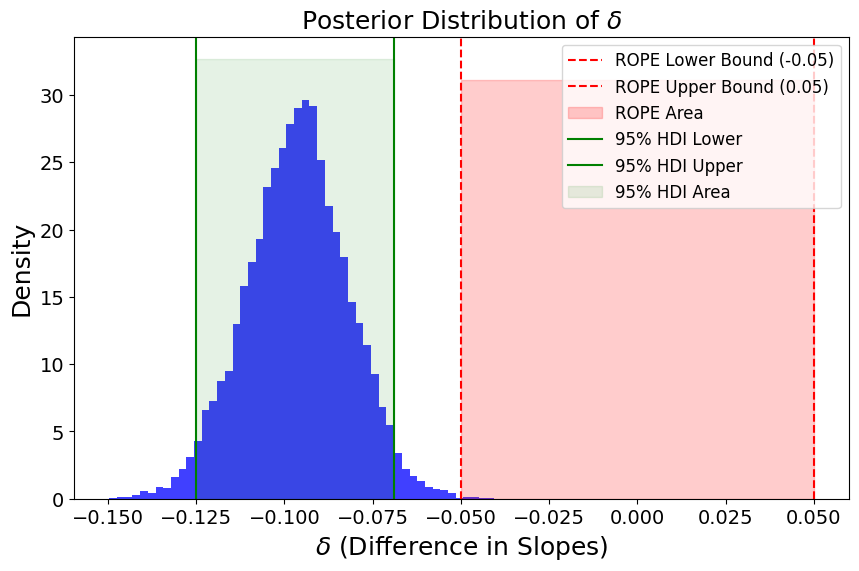

In [30]:
sorted_delta_samples = np.sort(delta_samples)

# Calculate 95% HDI
ci_index = int(0.95 * len(sorted_delta_samples))
lower_bound_index = np.arange(0, len(sorted_delta_samples) - ci_index)
hdi = np.array([sorted_delta_samples[i:i+ci_index] for i in lower_bound_index])
hdi_width = hdi[:, -1] - hdi[:, 0]
min_width_index = np.argmin(hdi_width)
hdi_lower = hdi[min_width_index, 0]
hdi_upper = hdi[min_width_index, -1]

print(f"95% HDI: [{hdi_lower}, {hdi_upper}]")

plt.figure(figsize=(10, 6))
plt.hist(delta_samples, bins=50, density=True, color='blue', alpha=0.75)
plt.title('Posterior Distribution of $\\delta$')
plt.xlabel('$\\delta$ (Difference in Slopes)')
plt.ylabel('Density')

# ROPE Visualization (assuming you've defined rope_lower and rope_upper)
plt.axvline(x=rope_lower, color='red', linestyle='--', label='ROPE Lower Bound (-0.05)')
plt.axvline(x=rope_upper, color='red', linestyle='--', label='ROPE Upper Bound (0.05)')
plt.fill_betweenx([0, plt.ylim()[1]], rope_lower, rope_upper, color='red', alpha=0.2, label='ROPE Area')

# HDI Visualization
plt.axvline(x=hdi_lower, color='green', linestyle='-', label='95% HDI Lower')
plt.axvline(x=hdi_upper, color='green', linestyle='-', label='95% HDI Upper')
plt.fill_betweenx([0, plt.ylim()[1]], hdi_lower, hdi_upper, color='green', alpha=0.1, label='95% HDI Area')

plt.legend()
plt.show()

7. Add your ROPE interval to the figure, using `ax.axvspan(...)` and `ax.axvline(...)`. Now use slide #6 from lecture 8 to answer the original research question. Does the active lifestyle have an effect in slowing down cognitive decline?

_ANSWER:_

If the 95% HDI of δ is entirely outside of the ROPE and primarily less than zero (since δ = slope of control - slope of active), it suggests that an active lifestyle has a significant effect in slowing cognitive decline, with the active group showing a lesser decline compared to the control.

See template below as aid for questions 5, 6, and 7.

## Note

If the fact that we draw a conclusion based on a fairly arbitrary ROPE makes you uneasy, then we agree. At the same time, if we used e.g. the Bayes factor approach (through Savage-Dickey or otherwise), the decision would depend on our choices of priors. The bottom line is that everything is, in the end, subjective.

A frequentist approach would implicitely assume $\mathcal{N}(0, \infty)$ priors on the regression coefficients, which is uninformative, but not reasonable. Neither statistical framework gets us a free lunch.

---

# 2. CO2 measurements at the Mauna Loa observatory

[The Mauna Loa observatory](https://gml.noaa.gov/obop/mlo/) is a research facility that measures all sorts of atmospheric properties, such as CO2 concentration (in parts-per-million, ppm). These data form a _timeseries_ (which is a fancy word for a regression problem where $x$ represents time).

The code below loads and visualizes this famous dataset:

In [31]:
import pandas as pd

## Load:
data = pd.read_csv('co2_mm_mlo.txt', delim_whitespace=True,
                   usecols=[0, 1, 2, 3], names=['Year', 'Month', 'Time', 'CO2'],
                   decimal=',')
x = data['Time'].to_numpy()  # in months
y = data['CO2'].to_numpy()   # CO2 per month

This type of timeseries often can be described by a number of different components. For instance, there is a clear _seasonal_ trend, representing the systematic fluctuations over the seasons as a kind of sine wave. In addition, there is the _upward_ trend (which is what we as a society need to worry about a lot).

In terms of statistical modelling, there are a number of important topics when it comes to timeseries:

* Can we predict the future?
* What kind of trends are present in the data?

First, we will take a look at the first topic, that of prediction. In order to figure out if our models make any sense, we will split the data into a _train set_ (all data up to [not including] 2010) and a _test set_ (all data starting at 2010):

**Note**: I make a distinction between the actual time (1990, 1990.1, ...) $t$ and the index $x$ (1, 2, ...). In theory we could use both as our predictors, but in practice it is easier to use the index $x$, because otherwise our sampler starts so very far away from the actual posterior distribution. So keep in mind: use $x$ to train your model and make predictions, but use $t$ for plotting.

In [32]:
index_of_2010 = 622  # The row in the file where year 2010 starts

time_train = x[:index_of_2010]
x_train = np.arange(len(time_train))
y_train = y[:index_of_2010]

time_test = x[index_of_2010:]
x_test = np.arange(len(time_test)) + len(time_train)
y_test = y[index_of_2010:]

n_train = len(x_train)
n_test = len(x_test)

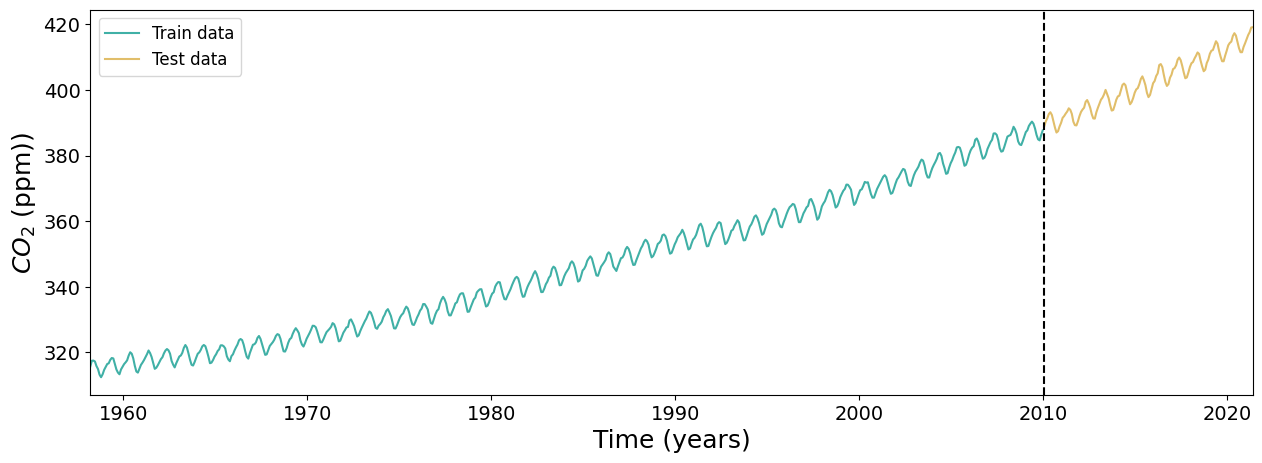

In [33]:
# Visualize data

colors = ['#40B0A6', '#E1BE6A']

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)]);

In this exercise, you'll construct three Bayesian models that you'll train on (`x_train`, `y_train`) and evaluate using (`x_test`, `y_test`).

**Note**: the models are extensions of each other; make sure the first is correct, then creating the extensions will be much easier.

### The linear model

The first model to try is a linear regression approach, which you have implemented/seen several times before.

1. Implement a Bayesian linear regression model, and learn the (approximated) posterior distribution $p(\beta_0, \beta_1, \sigma \mid \mathbf{x}_{\text{train}}, \mathbf{y}_{\text{train}})$. Feel free to re-use your (own!) JAGS code from previous exercises, or check the lecture slides. Make a figure with three subplots, one showing $\beta_0$, one showing $\beta_1$, and the last one showing $\sigma$. Do your plots seem sensible? Make sure to keep track of $\mu_i = \beta_0 + \beta_1 x_i$, you will need it later.

### Model Definition
\[
\begin{aligned}
y_i & \sim \mathcal{N}(\mu_i, \sigma^2) \quad \text{for } i = 1, \ldots, N \\
\mu_i & = \beta_0 + \beta_1 x_i \\
\beta_0 & \sim \mathcal{N}(0, 0.001) \\
\beta_1 & \sim \mathcal{N}(0, 0.001) \\
\sigma & \sim \mathcal{U}(0, 100) \\
\end{aligned}
\]

_ANSWER:_

adapting: iterations 4000 of 4000, elapsed 0:00:02, remaining 0:00:00
updating: iterations 4000 of 4000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 11180 of 40000, elapsed 0:00:09, remaining 0:00:24
sampling: iterations 17240 of 40000, elapsed 0:00:14, remaining 0:00:19
sampling: iterations 29468 of 40000, elapsed 0:00:21, remaining 0:00:08
sampling: iterations 40000 of 40000, elapsed 0:00:25, remaining 0:00:00


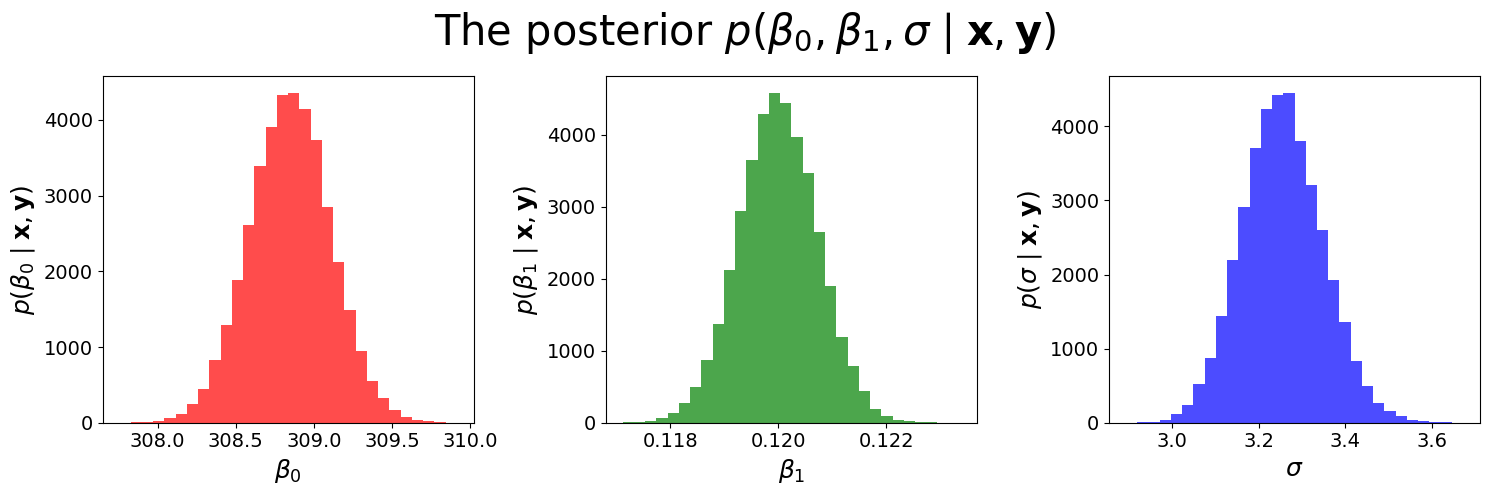

CPU times: user 22.2 s, sys: 216 ms, total: 22.4 s
Wall time: 30 s


In [34]:
%%time

model_code = """
model {
    beta0 ~ dnorm(0, 0.001)
    beta1 ~ dnorm(0, 0.001)
    sigma ~ dunif(0, 100)

    for (i in 1:N) {
        mu[i] <- beta0 + beta1 * x[i]
        y[i] ~ dnorm(mu[i], 1/pow(sigma, 2))
    }
}
"""
data_dict = {
    'x': x_train,
    'y': y_train,
    'N': n_train
}
num_samples = 10000
num_chains = 4
m_linear = pj.Model(code=model_code, data=data_dict, chains=num_chains)
m_linear.update(1000)
samples_linear = m_linear.sample(num_samples, vars=['beta0', 'beta1', 'sigma'])
beta0_samples = samples_linear['beta0'].flatten()
beta1_samples = samples_linear['beta1'].flatten()
sigma_samples = samples_linear['sigma'].flatten()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(beta0_samples, bins=30, alpha=0.7, color='r')
axes[0].set_xlabel(r'$\beta_0$')
axes[0].set_ylabel(r'$p(\beta_0 \mid \mathbf{x}, \mathbf{y}) $')

axes[1].hist(beta1_samples, bins=30, alpha=0.7, color='g')
axes[1].set_xlabel(r'$\beta_1$')
axes[1].set_ylabel(r'$p(\beta_1 \mid \mathbf{x}, \mathbf{y}) $')

axes[2].hist(sigma_samples, bins=30, alpha=0.7, color='b')
axes[2].set_xlabel(r'$\sigma$')
axes[2].set_ylabel(r'$p(\sigma \mid \mathbf{x}, \mathbf{y}) $')

plt.suptitle(r'The posterior $p(\beta_0, \beta_1, \sigma \mid \mathbf{x}, \mathbf{y})$');
plt.tight_layout()
plt.show()

The next task is to use this model to _predict_ what happened with the CO2 concentrations after 2010. In Bayesian terms, that means we want the posterior predictive distribution

$$
p(y^* \mid \mathbf{x}_{\text{train}}, \mathbf{y}_{\text{train}}) = \int\int\int p(y^* \mid \beta_0, \beta_1, \sigma, x^*) p(\beta_0, \beta_1, \sigma \mid \mathbf{x}_{\text{train}}, \mathbf{y}_{\text{train}})\, \text{d}\beta_0 \text{d}\beta_1 \text{d}\sigma \enspace.
$$

Here, $y^*$ indicates the CO2 concentrations at timepoint $x^*$, which is a point **not** in our training set.

Of course, we will not exactly solve this difficult triple integral, but we use JAGS to make an MCMC-based approximation. This is quite straightforward:

2. Copy your JAGS code to a new code cell. In your JAGS code you probably have a for loop similar to `for (i in 1:n_train) {...}`. Within this loop, you describe `y_train[i] ~ ...`. You now need to create an additional loop, but this one describes the **predicted** points. It is a loop over the points that we have not trained on: `for (j in 1:n_test) {...}`. **Important**: Do not provide `y_test` as data to JAGS, that would be cheating. Instead, sample `y_predict[j] ~ ...` and track JAGS' predictions. Your `samples['y_predict']` object should have shape `(n_test, num_samples, num_chains)`.

_ANSWER:_

### Model Definition
\[
\begin{aligned}
y_i & \sim \mathcal{N}(\mu_i, \sigma^2) \quad \text{for } i = 1, \ldots, N \\
\mu_i & = \beta_0 + \beta_1 x_i
\end{aligned}

\begin{aligned}
\beta_0 & \sim \mathcal{N}(0, 0.001) \\
\beta_1 & \sim \mathcal{N}(0, 0.001) \\
\sigma & \sim \mathcal{U}(0, 100)
\end{aligned}

\begin{aligned}
p(\beta_0, \beta_1, \sigma \mid y, x) \propto p(y \mid \beta_0, \beta_1, \sigma^2) \cdot p(\beta_0) \cdot p(\beta_1) \cdot p(\sigma)
\end{aligned}

\begin{aligned}
p(y \mid \beta_0, \beta_1, \sigma^2) = \prod_{i=1}^N \mathcal{N}(y_i \mid \beta_0 + \beta_1 x_i, \sigma^2)
\end{aligned}
\]


\[
\begin{aligned}
p(y^* \mid x^*, X_{\text{train}}, y_{\text{train}}) = \int \int \int p(y^* \mid \beta_0, \beta_1, \sigma^2, x^*) \, p(\beta_0, \beta_1, \sigma \mid X_{\text{train}}, y_{\text{train}}) \, d\beta_0 \, d\beta_1 \, d\sigma
\end{aligned}
\]


In [35]:
%%time

code = '''
model {
    beta0 ~ dnorm(0, 0.001)
    beta1 ~ dnorm(0, 0.001)
    sigma ~ dunif(0, 100)

    for (i in 1:N_train) {
        mu_train[i] <- beta0 + beta1 * x_train[i]
        y_train[i] ~ dnorm(mu_train[i], 1/pow(sigma, 2))
    }

    for (j in 1:N_test) {
        mu_test[j] <- beta0 + beta1 * x_test[j]
        y_predict[j] ~ dnorm(mu_test[j], 1/pow(sigma, 2))
    }
}
'''
data = dict(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    N_train=n_train,
    N_test=n_test
)
num_samples = 10000
num_chains = 4
m_linear = pj.Model(code=code, data=data, chains=num_chains)
m_linear.update(1000)
samples_linear = m_linear.sample(num_samples, vars=['beta0', 'beta1', 'sigma', 'y_predict'])
beta0_samples = samples_linear['beta0'].flatten()
beta1_samples = samples_linear['beta1'].flatten()
sigma_samples = samples_linear['sigma'].flatten()
y_predict_samples = samples_linear['y_predict']
mu_train = beta0_samples.mean() + beta1_samples.mean() * x_train

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
updating: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 21400 of 40000, elapsed 0:00:08, remaining 0:00:07
sampling: iterations 40000 of 40000, elapsed 0:00:14, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:14, remaining 0:00:00
CPU times: user 16.3 s, sys: 224 ms, total: 16.5 s
Wall time: 16.6 s


3. Copy the data visualization code and plot in addition the mean estimated $\mu_i$ over the training range. Furthermore, compute and visualize the mean and 95% HDI of the posterior predictive distribution. What is the expected CO2 concentration at the final observation (May 2021)?

_ANSWER:_ Predicted CO2 on May 2021: 399.8297493222882

Predicted CO2 on May 2021: 399.81899101424926


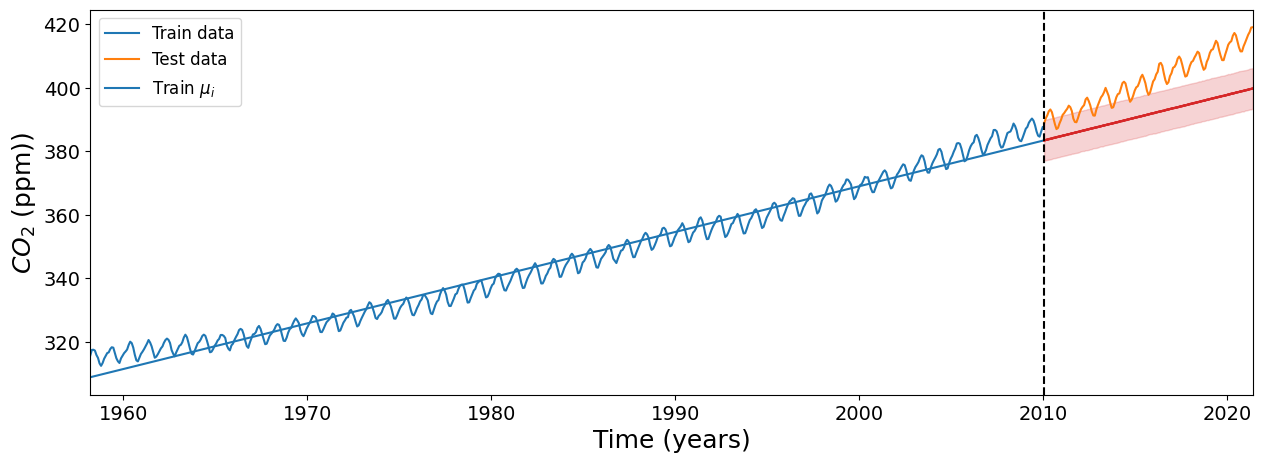

In [36]:
y_predict_mean = y_predict_samples.mean(axis=1)
y_predict_samples_reshaped = y_predict_samples.transpose(1, 2, 0).reshape(-1, data['N_test'])
y_predict_lb = np.percentile(y_predict_samples_reshaped, 2.5, axis=0)
y_predict_ub = np.percentile(y_predict_samples_reshaped, 97.5, axis=0)
colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_train, color='tab:blue',
        label='Train $\mu_i$')

ax.plot(time_test, y_predict_mean, color='tab:red')
ax.fill_between(time_test, y_predict_lb, y_predict_ub, color='tab:red',
                alpha=0.2)

ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)]);

print('Predicted CO2 on May 2021:',y_predict_mean[-1].mean());

The 95% HDI shows a nice and smooth interval, but the individual samples can be quite noisy.

4. Make a new figure that shows, instead of the 95% HDI, 5 randomly chosen samples of $\mathbf{y}_{\text{test}}$. Note that each sample is a vector of length 137, ranging from January 2010 to May 2021.

_ANSWER:_ Predicted CO2 on May 2021: 399.7993584630109

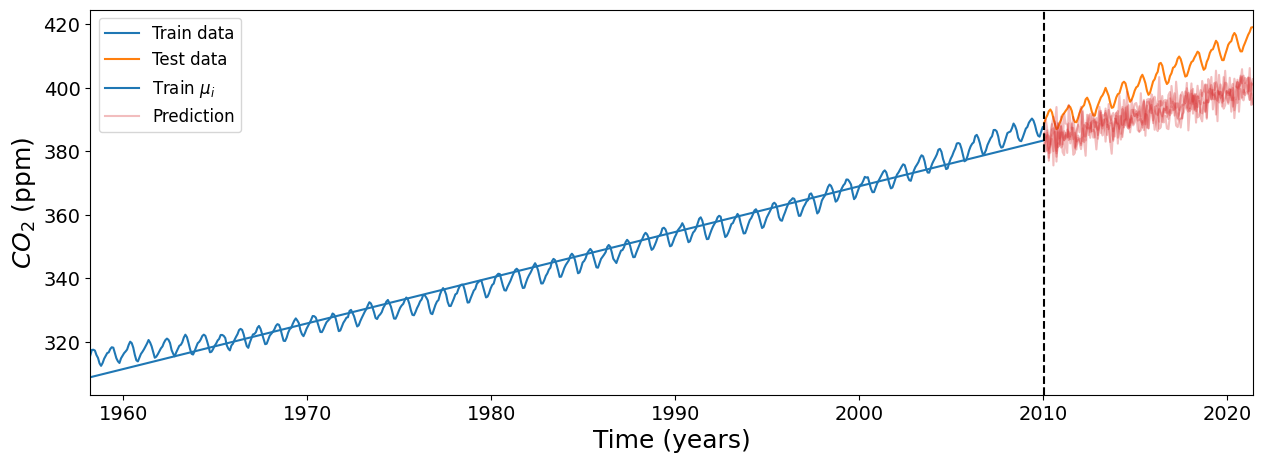

Predicted CO2 on May 2021: 399.81899101424926


In [37]:
N_test, num_samples, num_chains = y_predict_samples.shape
plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_train, color='tab:blue', label='Train $\mu_i$')
for i in range(5):
    sample_idx = np.random.randint(num_samples)
    chain_idx = np.random.randint(num_chains)
    ax.plot(time_test, y_predict_samples[:, sample_idx, chain_idx], color='tab:red', alpha=0.3, label='Prediction' if i == 0 else "")

ax.axvline(x=time_test[0], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm)')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)])
plt.show()
print('Predicted CO2 on May 2021:',y_predict_mean[-1].mean())

With the naked eye, we already know that our predictions are imperfect. We can quantify this into a (distribution of a) single number, so that we can later see whether changes to our model improve our predictions. One of the metrics to do this is the Mean Absolute Percentage Error (MAPE):

$$
  MAPE(\mathbf{y}^*, \mathbf{y}_{\text{test}}) = \frac{1}{n} \sum_{i=1}^n \frac{|y^*_i - y_{\text{test},i}|}{y_{\text{test},i}} \enspace.
$$

**(The lower the better!)**

The code below implements the calculation of the MAPE score for your predictions. The result is a distribution over MAPE scores, as we have a different score for every sample of the posterior predictive distribution.

5. Create the variable `y_predict_samples` from your MCMC output if you haven't already, and make sure it has shape `(n_test, num_chains*num_samples)`, then run the code below to make the histogram of MAPE scores.

_ANSWER:_

Shape of y_predict_samples: (137, 10000, 4)

Shape of y_predict_samples: (137, 10000, 4)


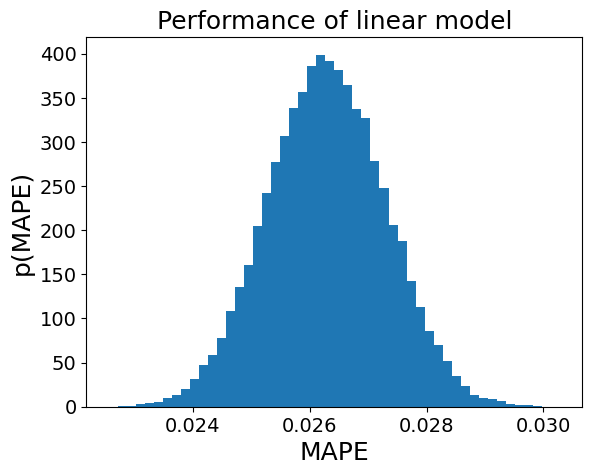

In [38]:
def mape(y_pred_):
    return np.mean(np.abs(y_pred_ - y_test) / y_test)

N_test, num_samples, num_chains = y_predict_samples.shape
y_predict_samples_reshaped = y_predict_samples.reshape(N_test, num_samples * num_chains)

print('Shape of y_predict_samples:', y_predict_samples.shape)
mape_scores = np.apply_along_axis(mape, 1, y_predict_samples_reshaped.T)

plt.figure()
plt.hist(mape_scores, density=True, bins=50)
plt.xlabel('MAPE')
plt.ylabel('p(MAPE)')
plt.title('Performance of linear model');

### The linear + seasonal model

In the previous steps, we use Bayesian linear regression to determine the CO2 predictions. That means something along the lines of (omitting priors for now):

$$
\begin{align*}
    \mu_i \mid \beta_0, \beta_1, x_i &= \beta_0 + \beta_1 x_i && i=1,\ldots,n\\
    y_i \mid \mu_i, \sigma & \sim \mathcal{N}(\mu_i, \sigma)  && i=1,\ldots,n\enspace.
\end{align*}
$$

It is straightforward to add the seasonal component of the observations into this model. In that case, we have:

$$
\begin{align*}
    \mu_i \mid \beta_0, \beta_1, \beta_2, \phi, x_i &= \beta_0 + \beta_1 x_i + \beta_2 \sin(2\pi / 12 x_i + \phi)  && i=1,\ldots,n\\
    y_i \mid \mu_i, \sigma & \sim \mathcal{N}(\mu_i, \sigma)  && i=1,\ldots,n\enspace.
\end{align*}
$$

The term $\beta_2$ is the coefficient that indicates how strong the seasonal influence is. The period of the sine wave is 12 months (hence $2\pi/12$), and $\phi$ is the _phase_ that tells us where the sine wave is at $x=0$. This is an additional parameter to learn, as we do not know exactly what this value should be.

6. Copy your previous model into the code block below, and add the seasonal part. For $\beta_2$, it makes sense to use the same priors as for the other regression coefficients. The phase $\phi$ is a value between 0 and the period of the sine wave (12) - what would be a sensible prior distribution here? Run your code and make the same figure as for subquestion 3, showing the actual observations, the mean $\mu_i$ over the range of the training data, and the posterior predictive distribution using its mean and its 95% HDI, over the range of the test data.

**Note**: This probably takes a bit longer to sample!

_ANSWER:_

In [39]:
%%time

code = '''
model{
    pi <- 3.141592653589793
    beta0 ~ dnorm(0, 0.001)
    beta1 ~ dnorm(0, 0.001)
    beta2 ~ dnorm(0, 0.001)
    phi ~ dunif(0, 2*pi)
    sigma ~ dunif(0, 100)

    for (i in 1:n_train) {
        mu_train[i] <- beta0 + beta1 * x_train[i] + beta2 * sin(2 * pi * x_train[i]/12+phi)
        y_train[i] ~ dnorm(mu_train[i], 1/pow(sigma, 2))
    }

    for (j in 1:n_test) {
        mu_test[j] <- beta0 + beta1 * x_test[j] + beta2 * sin(2 * pi * x_test[j] / 12 + phi)
        y_predict[j] ~ dnorm(mu_test[j], 1/pow(sigma, 2))
    }
}
'''

data = dict(x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            n_train=n_train,
            n_test=n_test)
num_samples = 10_000
num_chains = 4

m_seasonal = pj.Model(code=code, data=data, chains=num_chains)
samples_seasonal = m_seasonal.sample(num_samples, vars=['beta0','beta1','beta2','phi','sigma','y_predict'])

beta0_samples = samples_seasonal['beta0']
beta1_samples = samples_seasonal['beta1']
beta2_samples = samples_seasonal['beta2']
phi_samples = samples_seasonal['phi']
sigma_samples = samples_seasonal['sigma']
y_predict_samples = samples_seasonal['y_predict']

adapting: iterations 4000 of 4000, elapsed 0:00:06, remaining 0:00:00
adapting: iterations 4000 of 4000, elapsed 0:00:06, remaining 0:00:00
sampling: iterations 5636 of 40000, elapsed 0:00:11, remaining 0:01:05
sampling: iterations 10960 of 40000, elapsed 0:00:20, remaining 0:00:52
sampling: iterations 16552 of 40000, elapsed 0:00:29, remaining 0:00:41
sampling: iterations 22268 of 40000, elapsed 0:00:39, remaining 0:00:31
sampling: iterations 28020 of 40000, elapsed 0:00:48, remaining 0:00:20
sampling: iterations 30948 of 40000, elapsed 0:00:53, remaining 0:00:16
sampling: iterations 33848 of 40000, elapsed 0:00:58, remaining 0:00:11
sampling: iterations 36748 of 40000, elapsed 0:01:03, remaining 0:00:06
sampling: iterations 40000 of 40000, elapsed 0:01:09, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:01:09, remaining 0:00:00
CPU times: user 1min 14s, sys: 355 ms, total: 1min 14s
Wall time: 1min 15s


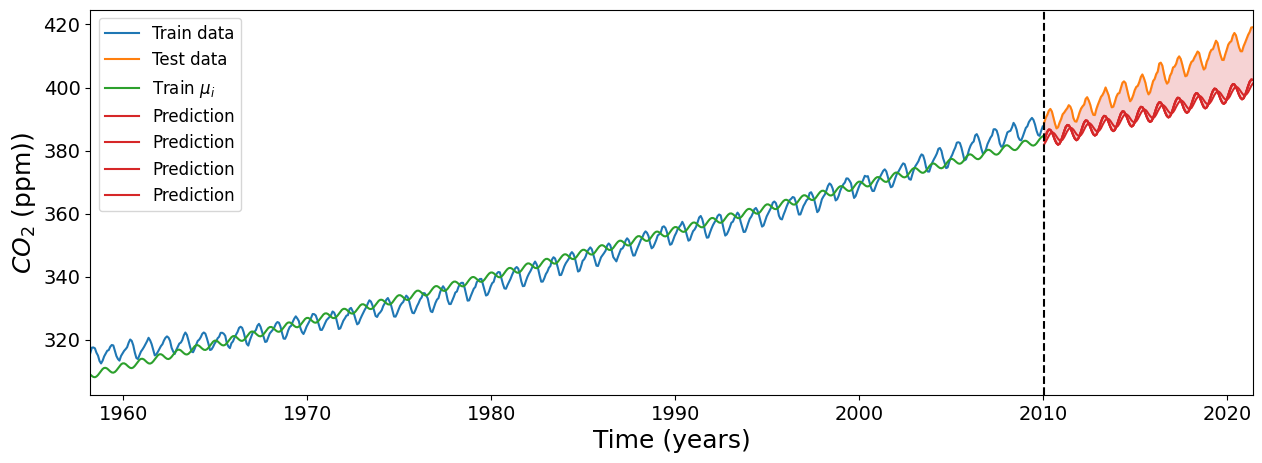

Predicted CO2 on May 2021: 402.1311892256508


In [40]:
y_predict_mean = y_predict_samples.mean(axis=1)
# y_predict_lb = np.percentile(y_predict_samples_reshaped, 2.5, axis=0)
# y_predict_ub =  np.percentile(y_predict_samples_reshaped, 97.5, axis=0)
mu_train = beta0_samples.mean() + beta1_samples.mean() * x_train + beta2_samples.mean() * np.sin(2 * np.pi * x_train / 12 + phi_samples.mean())

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_train,
        color='tab:green', label='Train $\mu_i$')
ax.plot(time_test, y_predict_mean, color='tab:red', label='Prediction')
# ax.fill_between(time_test, y_predict_lb, y_predict_ub, color='tab:red',alpha=0.2)
ax.fill_between(time_test, y_predict_mean.mean(axis=1), y_test, color='tab:red', alpha=0.2)
ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)]);
plt.show()

expected_co2_may_2021 = y_predict_mean[-1]
print('Predicted CO2 on May 2021:', expected_co2_may_2021.mean()) # Taking mean of 4 chains ofc

7. Make a figure with two overlapping histograms; one showing the MAPE scores for the predictions using the linear model, and one showing the MAPE scores for the predictions using the new model that combines the linear and seasonal trends. Do you see, as expected, a reduction in MAPE?

**Note**: It would be nice to add a formal Bayesian model comparison between the two models, and test whether one is better than the other. In the interest of focusing on timeseries we omit that now.

_ANSWER:_

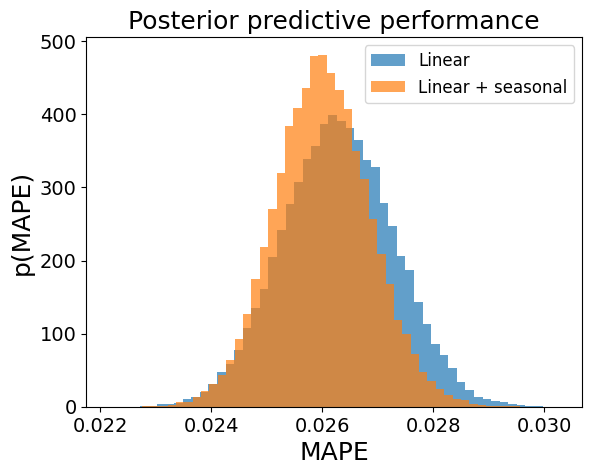

In [41]:
def mape(y_pred_):
    return np.mean(np.abs(y_pred_ - y_test) / y_test)


y_predict_samples_seasonal = samples_seasonal['y_predict']
N_test, num_samples_seasonal, num_chains_seasonal = y_predict_samples_seasonal.shape
y_predict_samples_seasonal_reshaped = y_predict_samples_seasonal.reshape(N_test, num_samples_seasonal * num_chains_seasonal).T
y_predict_samples_linear = samples_linear['y_predict']
N_test, num_samples_linear, num_chains_linear = y_predict_samples_linear.shape
y_predict_samples_linear_reshaped = y_predict_samples_linear.reshape(N_test, num_samples_linear * num_chains_linear).T
mape_scores_seasonal = np.apply_along_axis(mape, 1, y_predict_samples_seasonal_reshaped)
mape_scores_linear = np.apply_along_axis(mape, 1, y_predict_samples_linear_reshaped)
plt.figure()
plt.hist(mape_scores_linear, density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(mape_scores_seasonal, density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.xlabel('MAPE')
plt.ylabel('p(MAPE)')
plt.title('Posterior predictive performance')
plt.legend();

The parameter $\sigma$ in $y_i \mid \mu_i, \sigma \sim \mathcal{N}(\mu_i, \sigma)$ indicates how much the actual observations vary around the predicted mean.

8. Make a figure with two overlapping histograms again, this time showing the posterior distribution of $\sigma$ according to either the linear, or the linear+seasonal trends. Why is $\sigma$ lower for the linear+seasonal model?

_ANSWER:_


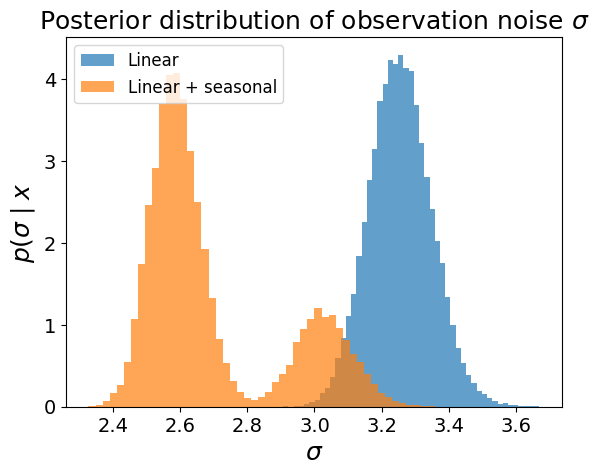

In [42]:
plt.figure()
plt.hist(samples_linear['sigma'].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(samples_seasonal['sigma'].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p(\sigma\mid x}, y)$')
plt.title(r'Posterior distribution of observation noise $\sigma$')
plt.legend();

## The linear + seasonal + quadratic model

Both the MAPE and the posterior distribution of $\sigma$ (and of course the visualization of the predictions themselves) confirm that the seasonal trend is a welcome addition when trying to model the CO2 concentrations in the air around Mauna Loa. However, there's definitely room for improvement still.

By looking at the model fits and predictions, we see that the linear trend works well in the middle of the training range, but is incorrect near the edges (and therefore also near the range we are interested in most; after 2010!). A higher-order trend (like **quadratic**) might be helpful here:

$$
\begin{align*}
    \mu_i \mid \beta_0, \beta_1, \beta_2, \beta_3, \phi x_i &= \beta_0 + \beta_1 x_i + \beta_2 \sin(2\pi / 12 x_i + \phi)  + \beta_3 x_i^2&& i=1,\ldots,n\\
    y_i \mid \mu_i, \sigma & \sim \mathcal{N}(\mu_i, \sigma)  && i=1,\ldots,n\enspace.
\end{align*}
$$

9. Copy your previous JAGS code to the cell below and add the quadratic term. Repeat the steps from before: plot the predictions, plot the MAPE (for all three models in a single figure) and plot the posterior of $\sigma$ (also for all three models in a single figure).

_ANSWER:_

In [43]:
%%time
code = '''
model {
    pi <- 3.14159265
    beta0 ~ dnorm(0, 0.001)
    beta1 ~ dnorm(0, 0.001)
    beta2 ~ dnorm(0, 0.001)
    beta3 ~ dnorm(0, 0.001)
    phi ~ dunif(0, 2 * pi)
    sigma ~ dunif(0, 100)

    for (i in 1:n_train) {
        mu_train[i] <- beta0 + beta1 * x_train[i] + beta2 * sin(2 * pi * x_train[i] / 12 + phi) + beta3 * pow(x_train[i], 2)
        y_train[i] ~ dnorm(mu_train[i], 1 / pow(sigma, 2))
    }

    for (j in 1:n_test) {
        mu_test[j] <- beta0 + beta1 * x_test[j] + beta2 * sin(2 * pi * x_test[j] / 12 + phi) + beta3 * pow(x_test[j], 2)
        y_predict[j] ~ dnorm(mu_test[j], 1 / pow(sigma, 2))
    }
}
'''
num_samples = 10_000
num_chains = 4
data = dict(x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            n_train=n_train,
            n_test=n_test)
m_quad = pj.Model(code=code, data=data, chains=num_chains)
samples_quad = m_quad.sample(num_samples, vars=['beta0', 'beta1', 'beta2', 'beta3', 'sigma', 'y_predict'])

adapting: iterations 4000 of 4000, elapsed 0:00:07, remaining 0:00:00
adapting: iterations 4000 of 4000, elapsed 0:00:07, remaining 0:00:00
sampling: iterations 4660 of 40000, elapsed 0:00:08, remaining 0:00:57
sampling: iterations 7744 of 40000, elapsed 0:00:13, remaining 0:00:56
sampling: iterations 10620 of 40000, elapsed 0:00:19, remaining 0:00:52
sampling: iterations 13452 of 40000, elapsed 0:00:30, remaining 0:01:00
sampling: iterations 17928 of 40000, elapsed 0:00:39, remaining 0:00:48
sampling: iterations 22500 of 40000, elapsed 0:00:48, remaining 0:00:37
sampling: iterations 27212 of 40000, elapsed 0:00:56, remaining 0:00:26
sampling: iterations 32080 of 40000, elapsed 0:01:05, remaining 0:00:16
sampling: iterations 37028 of 40000, elapsed 0:01:13, remaining 0:00:06
sampling: iterations 39556 of 40000, elapsed 0:01:18, remaining 0:00:01
sampling: iterations 40000 of 40000, elapsed 0:01:19, remaining 0:00:00
CPU times: user 1min 20s, sys: 330 ms, total: 1min 21s
Wall time: 1min

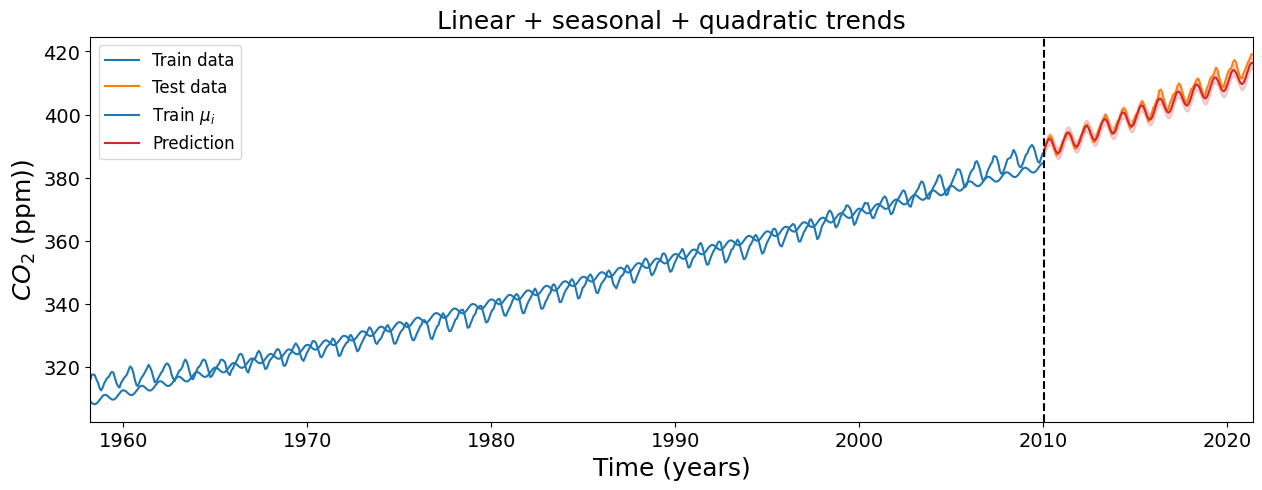

In [44]:
y_predict_samples_quad = samples_quad['y_predict'].transpose(1, 2, 0).reshape(-1, n_test)
y_predict_mean = y_predict_samples_quad.mean(axis=0)
y_predict_lb = np.percentile(y_predict_samples_quad, 2.5, axis=0)
y_predict_ub = np.percentile(y_predict_samples_quad, 97.5, axis=0)

plt.figure(figsize=(15, 5))
ax = plt.gca()
ax.plot(time_train, y_train, color=colors[0], label='Train data')
ax.plot(time_test, y_test, color=colors[1], label='Test data')
ax.plot(time_train, mu_train, color='tab:blue',
        label='Train $\mu_i$')
ax.plot(time_test, y_predict_mean, color='tab:red', label='Prediction')
ax.fill_between(time_test, y_predict_lb, y_predict_ub, color='tab:red',
                alpha=0.2)

ax.axvline(x=x[index_of_2010], ls='--', color='k')
ax.set_xlabel('Time (years)')
ax.set_ylabel(r'$CO_2$ (ppm))')
ax.legend()
ax.set_xlim([np.min(x), np.max(x)])
ax.set_title('Linear + seasonal + quadratic trends');

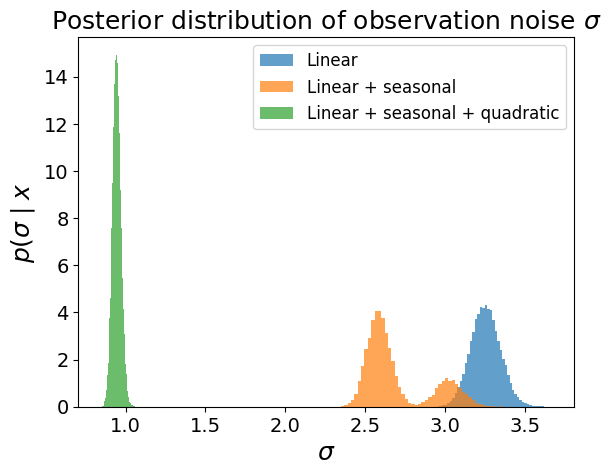

In [45]:
plt.figure()
plt.hist(samples_linear['sigma'].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(samples_seasonal['sigma'].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.hist(samples_quad['sigma'].flatten(), density=True, bins=50, alpha=0.7,
         label='Linear + seasonal + quadratic')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p(\sigma\mid x}, y)$')
plt.title(r'Posterior distribution of observation noise $\sigma$')
plt.legend();

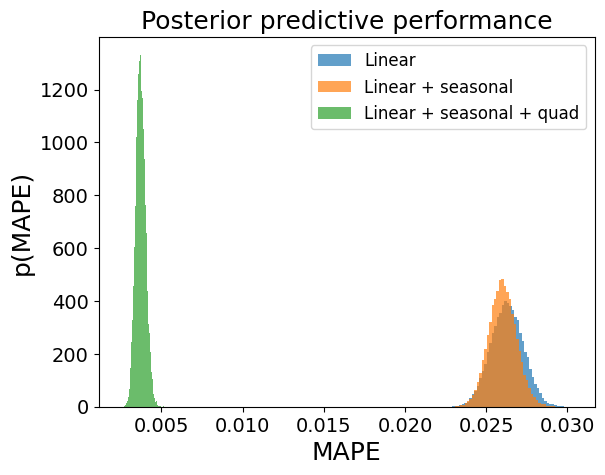

In [46]:
def mape(y_pred_):
    return np.mean(np.abs(y_pred_ - y_test) / y_test)

mape_scores_quad = np.apply_along_axis(mape, 1,
                                           y_predict_samples_quad)
mape_scores_seasonal = np.apply_along_axis(mape, 1,
                                           y_predict_samples_seasonal_reshaped)
mape_scores_linear = np.apply_along_axis(mape, 1,
                                         y_predict_samples_linear_reshaped)

plt.figure()
plt.hist(mape_scores_linear, density=True, bins=50, alpha=0.7,
         label='Linear')
plt.hist(mape_scores_seasonal, density=True, bins=50, alpha=0.7,
         label='Linear + seasonal')
plt.hist(mape_scores_quad, density=True, bins=50, alpha=0.7,
         label='Linear + seasonal + quad')
plt.xlabel('MAPE')
plt.ylabel('p(MAPE)')
plt.title('Posterior predictive performance')
plt.legend();


When fitting models to training data, we know that we will always obtain a better fit with a complex model than with a simple one. Our last model is definitely the most complex. For example, the linear model is just a special case of it, with $\beta_2=\beta_3=0$.

We saw in lecture 7 how Bayesian model comparison through Bayes factors / marginal likelihoods has a form of Occam's razor built-in, that adjusts for model complexity. However, here we computed the predictive performance of the models instead (using the MAPE).

10. Argue why we did or did not overfit in this exercise.

_ANSWER:_

Since we use separate parts of data for training process and test process it help generalization.

Also, most complex model has significant difference in error (low one) and the lower value for sigma proves that it closely matches the training data reducing error.



---
# 3. Predicting diabetes

For the final exercise of this assignment we'll be looking into a logistic regression example (see Lecture 06). This is essentially Bayesian classification.

The dataset from this study comes from a Kaggle competition and was collected by the National Institute of Diabetes and Digestive and Kidney Diseases, and contains measurements for $n=768$ women of Pima Indian Heritage. The measurements consist of diagnostic information such as glucose levels, BMI, number of pregnancies, and so forth. Our job is to predict the outcome variable 'diabetes' (0 for no, 1 for yes) based on these predictors, and to figure out which variables are most important for this diagnosis.

The code block below loads the data and does some minor preprocessing so the data are 'nice' to work with.

Note: This is a relatively large dataset, which means that a JAGS model might run for quite a while. For debugging, you can just use the first $m \ll n$ records of course!

In [47]:
import pandas as pd

def zscale(x):
    return (x - np.mean(x)) / np.std(x)

#

# Load dataset
df = pd.read_csv('diabetes.csv', sep=',', header=0)

# We have some missing values; glucose, blood pressure, skin thickness, insulin, BMI, DiabetesPedigreeFunction contain zeros which is impossible
# We fill in these missing values by *imputing* the median

for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']:
    df[col] = df[col].replace(0, df[col].median())

# Since the predictors are measured in different units, we rescale them so we can interpret the corresponding coefficients later on

for col in ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']:
    df[col] = zscale(df[col])

df['Age'] = df['Age'] / 100

# The predictors in numpy format:
X = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']].to_numpy()

# And the outcome that we will try to predict
y = df['Outcome']

n, p = X.shape

# split train/test

train_fraction = 0.8
n_train = int(n*train_fraction)
n_test = n - n_train

X_train = X[0:n_train, :]
y_train = y[0:n_train]

X_test = X[n_train:, :]
y_test = y[n_train:]

The code above also splits the data into a set for training and a set for testing; that will tell us how well our model generalizes to new observations.

1. Implement a logistic regression model in JAGS and train it on the training data `X_train` and `y_train`. Don't forget to include an intercept term $\beta_0$!

adapting: iterations 1113 of 3000, elapsed 0:00:06, remaining 0:00:10
adapting: iterations 2058 of 3000, elapsed 0:00:11, remaining 0:00:05
adapting: iterations 3000 of 3000, elapsed 0:00:16, remaining 0:00:00
sampling: iterations 822 of 6000, elapsed 0:00:05, remaining 0:00:33
sampling: iterations 2469 of 6000, elapsed 0:00:13, remaining 0:00:19
sampling: iterations 3384 of 6000, elapsed 0:00:19, remaining 0:00:15
sampling: iterations 5157 of 6000, elapsed 0:00:28, remaining 0:00:05
sampling: iterations 6000 of 6000, elapsed 0:00:34, remaining 0:00:00
sampling: iterations 6000 of 6000, elapsed 0:00:34, remaining 0:00:00


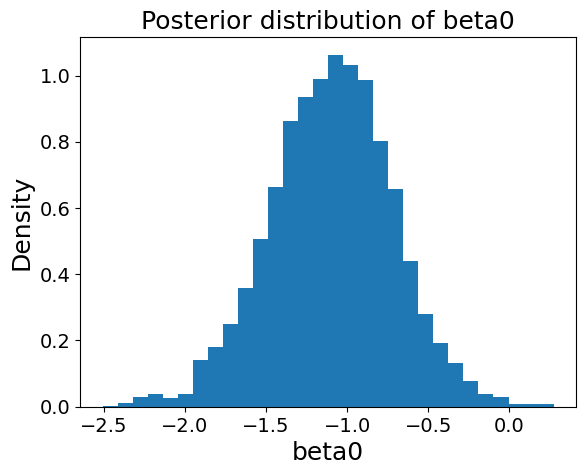

In [48]:
model = '''
model {
    # Prior distributions for the parameters
    beta0 ~ dnorm(0, 0.01)  # Prior for the intercept
    for (j in 1:P) {
        beta[j] ~ dnorm(0, 0.01)  # Priors for the predictor coefficients
    }

    # Likelihood
    for (i in 1:N) {
        y[i] ~ dbern(p[i])  # Bernoulli distribution for the outcome
        logit(p[i]) = beta0 + inprod(beta[], X[i,])  # Linear predictor
    }
}
'''

data = {
    'X': X_train,  # Predictor matrix
    'y': y_train,  # Response vector
    'N': len(y_train),  # Number of observations
    'P': X_train.shape[1]  # Number of predictors
}

import numpy as np

init_values = [
    {'beta0': 0, 'beta': np.zeros(X_train.shape[1])} for _ in range(3)
]



model = pj.Model(model, data=data, init=init_values, chains=3)
samples = model.sample(2000, vars=['beta0', 'beta'])

# Plotting the posterior distribution for the intercept
beta0_samples = samples['beta0']
beta_samples = samples['beta'].reshape(-1, X_train.shape[1])
flat_beta0_samples = beta0_samples.flatten()
plt.hist(flat_beta0_samples, bins=30, density=True)
plt.title('Posterior distribution of beta0')
plt.xlabel('beta0')
plt.ylabel('Density')
plt.show()

2. Make a figure showing for all predictors a histogram of the distribution and the 95% HDI interval indicated as a shaded area (for an example, see slide 45 in Lecture 06). Using the standard approach from the course, which predictors are important in predicting whether someone will have diabetes?

Shape of beta_samples: (6000, 8)


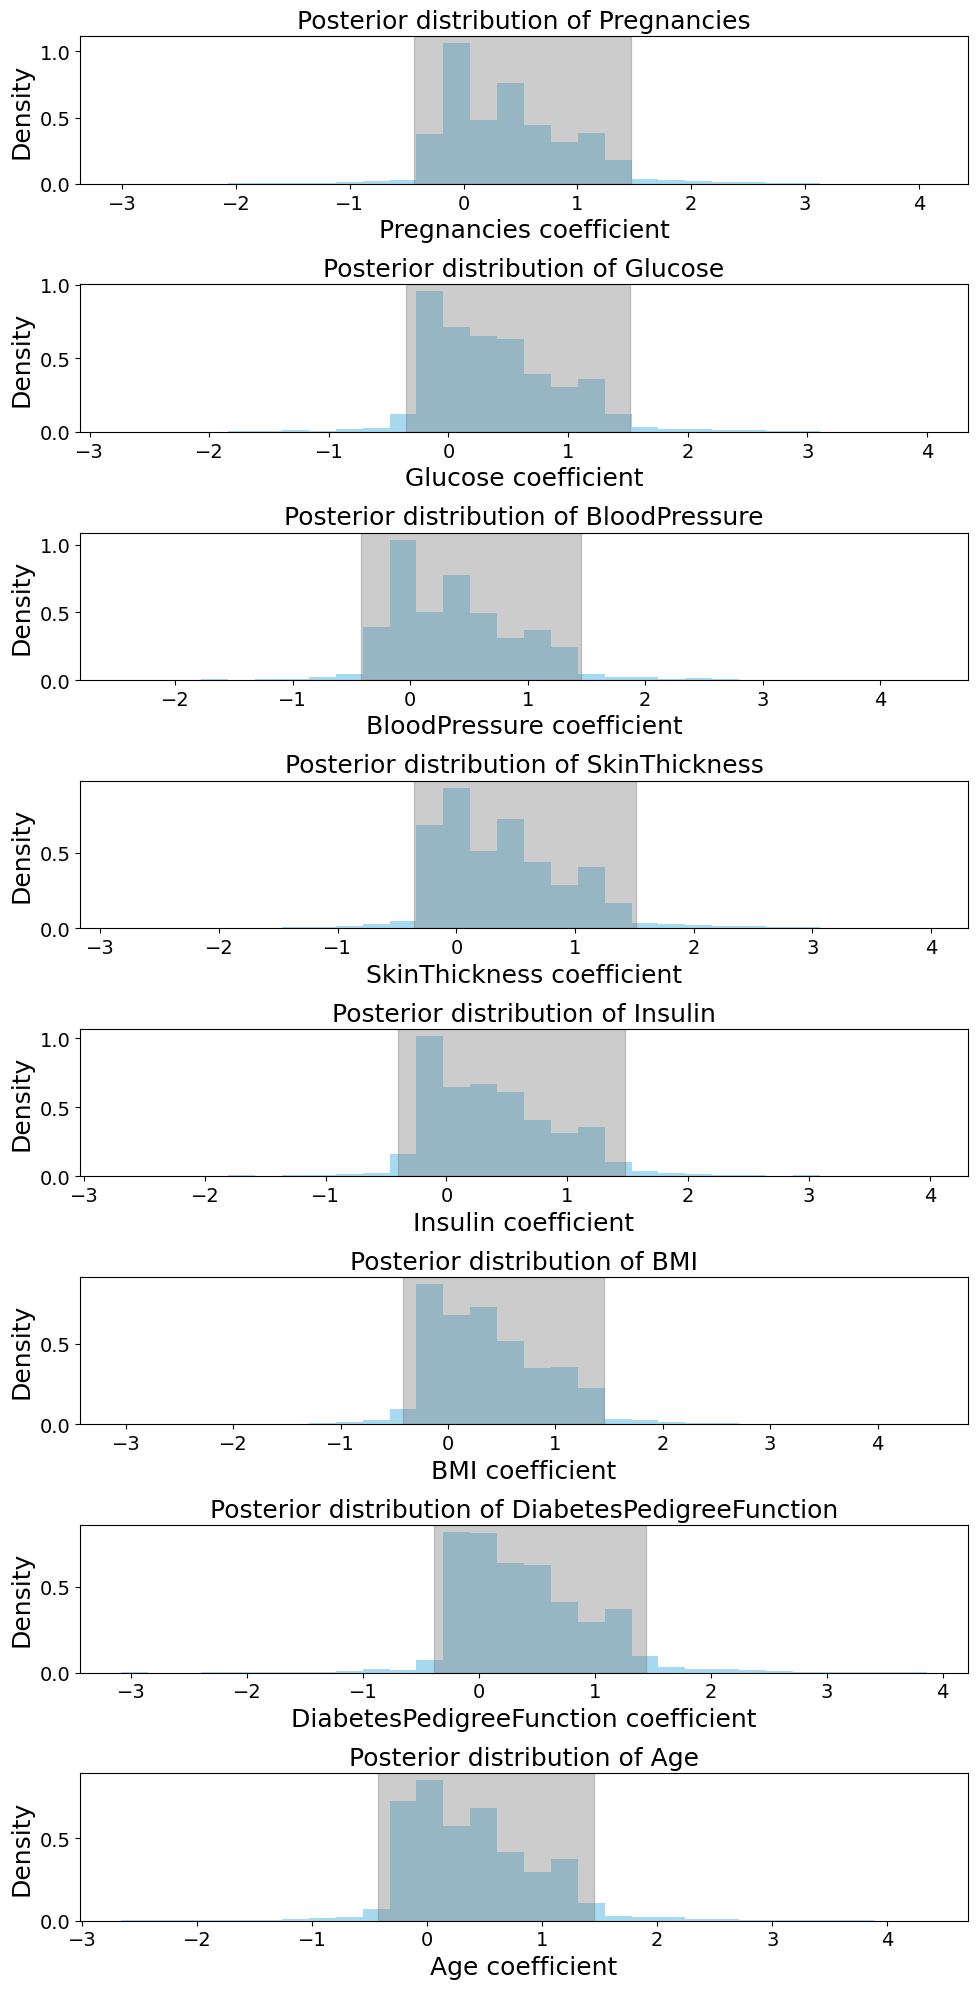

In [49]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def hdi(samples, cred_mass=0.95):
    sorted_samples = np.sort(samples)
    ci_idx_inc = int(np.floor(cred_mass * len(sorted_samples)))
    n_cis = len(sorted_samples) - ci_idx_inc
    ci_width = [sorted_samples[i + ci_idx_inc] - sorted_samples[i] for i in range(n_cis)]
    min_idx = ci_width.index(min(ci_width))
    hdi_min = sorted_samples[min_idx]
    hdi_max = sorted_samples[min_idx + ci_idx_inc]
    return hdi_min, hdi_max

# Check the shape
print("Shape of beta_samples:", beta_samples.shape)

# Adjust number of plots based on actual number of predictors
fig, axes = plt.subplots(nrows=beta_samples.shape[1], ncols=1, figsize=(10, 20))
axes = axes.flatten()  # Flatten axes array if only one column

for i, ax in enumerate(axes):
    ax.hist(beta_samples[:, i], bins=30, density=True, color='skyblue', alpha=0.75)
    hdi_min, hdi_max = hdi(beta_samples[:, i])
    ax.add_patch(patches.Rectangle((hdi_min, 0), hdi_max - hdi_min, ax.get_ylim()[1], color='gray', alpha=0.4))
    ax.set_title(f'Posterior distribution of {predictor_names[i]}')
    ax.set_ylabel('Density')
    ax.set_xlabel(f'{predictor_names[i]} coefficient')

plt.tight_layout()
plt.show()

Now let's see how well our model can predict diabetes for data it has not yet seen.

We can do this via the posterior predictive distribution $p(y^* \mid \mathbf{y})$, but because this distribution includes all the uncertainty of our parameters, plus the uncertainty of the predictive distribution, it is very wide. If we sample a prediction from such a wide distribution, it will often be wrong, because of this width.

If we just want to look at the performance of the logistic regression model as a classifier, it is helpful to summarize the distributions of the regression parameters with their expectation instead. As you recall, you can obtain these by simply taking the mean over your samples.

Compute the mean of your model parameters (intercept and coefficients) and using those means, compute for every test individual $i$ (with predictors $\mathbf{x}_i^*) $the probability
$$
\mu_i^*= p(y_i^* =1 \mid \mathbf{y}) = \text{logit}^{-1}\left( \bar{\beta}_0 + \bar{\mathbf{\beta}}(\mathbf{x}_i^*)^\top\right)
$$ where the bar symbol $\bar{\cdot}$ indicates the posterior mean of those parameters.

Now $\mu_i^*$ is the probability that  $y_i^*=1$, so we can apply a threshold to obtain an actual prediction. Let's say the predictions are $y_i^* = \mu_i^* > 0.5$.

3. Use these predictions as the output of your Bayesian classifier. What is the accuracy of this tool?

In [50]:
# Assuming 'beta0_samples' and 'beta_samples' contain samples from the posterior distributions
mean_beta0 = np.mean(beta0_samples)
mean_betas = np.mean(beta_samples, axis=0)  # mean across all samples for each predictor

def logistic(x):
    return 1 / (1 + np.exp(-x))

# Compute the linear predictor for each test example
linear_predictor = mean_beta0 + np.dot(X_test, mean_betas)

# Apply the logistic function to get probabilities
predicted_probabilities = logistic(linear_predictor)

predictions = (predicted_probabilities > 0.5).astype(int)

# True labels are in 'y_test'
accuracy = np.mean(predictions == y_test)
print(f"Accuracy of the Bayesian logistic regression classifier: {accuracy * 100:.2f}%")


Accuracy of the Bayesian logistic regression classifier: 74.03%
